# Quantiacs Toolbox Sample: Linear regression
This tutorial will show you how to use linear regression with the Quantiacs Toolbox to predict the return of a portfolio.
A simple linear regression can be extended by constructing polynomial features from the coefficients.
We will use a polynomial regression to fit the daily closing price of the past year to predict trend of next day.

In [1]:
import quantiacsToolbox
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
%matplotlib inline

For developing and testing a strategy, we will use the raw data in the tickerData folder that has been downloaded with the Toolbox's loadData function.

This is just a simple sample to show how linear regression works.  
Here we extract the closing price of the Australian Dollar futures (F_AD) for the last year:

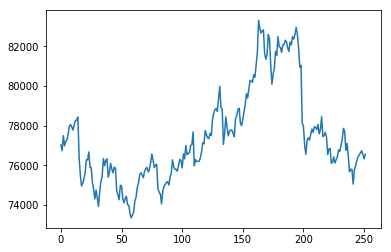

In [2]:
F_AD = pd.read_csv('./tickerData/F_AD.txt')
CLOSE = np.array(F_AD.loc[:252-1, [' CLOSE']])
plt.plot(CLOSE)

Create samples:

In [3]:
poly = PolynomialFeatures(degree=5)
X = poly.fit_transform(np.arange(252).reshape(-1, 1))
y = CLOSE[:]

Use linear regression learn and predict:

/Users/yizhengzhao/Library/Python/2.7/lib/python/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


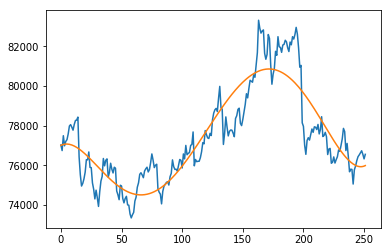

In [4]:
reg = linear_model.LinearRegression()
reg.fit(X, y)
plt.plot(y)
plt.plot(reg.predict(X))

As we can see the model can roughly fit the price.  
Now we can predict the next day's close price:

In [5]:
reg.predict(poly.fit_transform(np.array([[252]])))

array([[ 76017.68619541]])

Compare with real price:

In [6]:
F_AD.loc[252, [' CLOSE']]

 CLOSE    76560.0
Name: 252, dtype: float64

#### Hooray! Our strategy successfully predicted the price.
#### Now we use the Quantiacs Toolbox to run our strategy.

In [7]:
class myStrategy(object):

    def myTradingSystem(self, DATE, OPEN, HIGH, LOW, CLOSE, VOL, OI, P, R, RINFO, exposure, equity, settings):
        """ This system uses linear regression to allocate capital into the desired equities"""

        # Get parameters from setting
        nMarkets = len(settings['markets'])
        lookback = settings['lookback']
        dimension = settings['dimension']
        threshold = settings['threshold']

        pos = np.zeros(nMarkets, dtype=np.float)

        poly = PolynomialFeatures(degree=dimension)
        for market in range(nMarkets):
            reg = linear_model.LinearRegression()
            try:
                reg.fit(poly.fit_transform(np.arange(lookback).reshape(-1, 1)), CLOSE[:, market])
                trend = (reg.predict(poly.fit_transform(np.array([[lookback]]))) - CLOSE[-1, market]) / CLOSE[-1, market]

                if abs(trend[0]) < threshold:
                    trend[0] = 0

                pos[market] = np.sign(trend)

            # for NaN data set position to 0
            except ValueError:
                pos[market] = .0

        return pos, settings


    def mySettings(self):
        """ Define your trading system settings here """

        settings = {}

        # Futures Contracts
        settings['markets'] = ['CASH', 'F_AD', 'F_BO', 'F_BP', 'F_C', 'F_CC', 'F_CD',
                               'F_CL', 'F_CT', 'F_DX', 'F_EC', 'F_ED', 'F_ES', 'F_FC', 'F_FV', 'F_GC',
                               'F_HG', 'F_HO', 'F_JY', 'F_KC', 'F_LB', 'F_LC', 'F_LN', 'F_MD', 'F_MP',
                               'F_NG', 'F_NQ', 'F_NR', 'F_O', 'F_OJ', 'F_PA', 'F_PL', 'F_RB', 'F_RU',
                               'F_S', 'F_SB', 'F_SF', 'F_SI', 'F_SM', 'F_TU', 'F_TY', 'F_US', 'F_W', 'F_XX',
                               'F_YM']

        settings['lookback'] = 252
        settings['budget'] = 10 ** 6
        settings['slippage'] = 0.05

        settings['threshold'] = 0.2
        settings['dimension'] = 3

        return settings

Loading Data...
Done! 
Evaluating Trading System


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/quantiacsToolbox/quantiacsToolbox.py:428: RuntimeWarning: invalid value encountered in divide
  position = position/np.sum(abs(position))


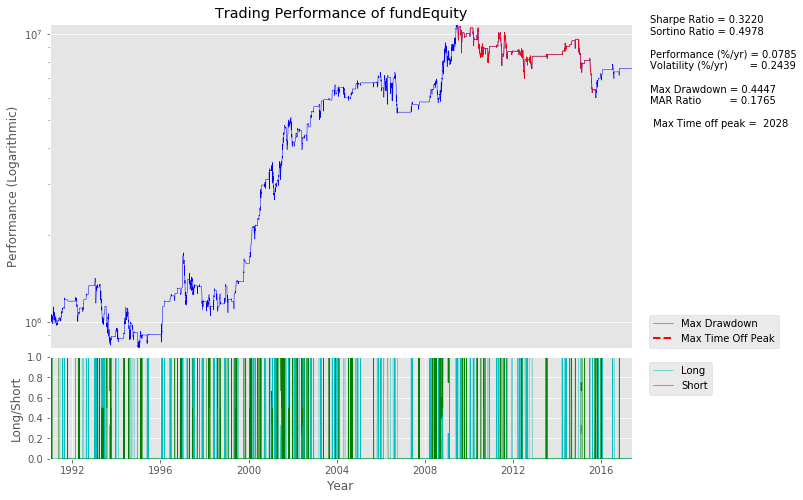

In [8]:
result = quantiacsToolbox.runts(myStrategy)

** Congrats! You just finished your first linear regression strategy.**  

Try to optimize it!  

**Quantiacs https://www.quantiacs.com/**